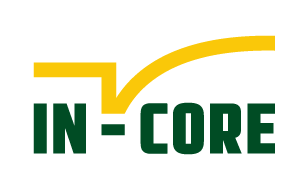


# Population Dislocation Analysis

**Jupyter Notebook Created by**:
   - Mehrzad Rahimi, Postdoctoral fellow at Rice University (mr77@rice.edu)
   - Nathanael Rosenheim, Research Associate Professor at Texas A&M University (nrosenheim@arch.tamu.edu)
   - Jamie E. Padgett, Professor at Rice University (jamie.padgett@rice.edu)

## 1) Initialization

In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
import pandas as pd
import geopandas as gpd 
import numpy as np
import sys 
import os 
import glob
import matplotlib.pyplot as plt
import contextily as ctx
import copy
import math
from scipy.stats import norm
from pathlib import Path

from pyincore import IncoreClient, Dataset, DataService, HazardService, FragilityService, MappingSet, FragilityCurveSet
from pyincore_viz.geoutil import GeoUtil as geoviz
from pyincore_viz.plotutil import PlotUtil as plotviz

# importing pyIncone analyses:
from pyincore.analyses.buildingdamage import BuildingDamage
from pyincore.analyses.bridgedamage import BridgeDamage
from pyincore.analyses.roaddamage import RoadDamage
from pyincore.analyses.epfdamage import EpfDamage
from pyincore.analyses.buildingfunctionality import BuildingFunctionality
from pyincore.analyses.housingunitallocation import HousingUnitAllocation
from pyincore.analyses.populationdislocation import PopulationDislocation, PopulationDislocationUtil
from pyincore.analyses.housingrecoverysequential import HousingRecoverySequential

In [2]:
# Check package versions - good practice for replication
print("Python Version ", sys.version)
print("pandas version: ", pd.__version__)
print("numpy version: ", np.__version__)

Python Version  3.9.12 | packaged by conda-forge | (main, Mar 24 2022, 23:23:20) 
[Clang 12.0.1 ]
pandas version:  1.4.2
numpy version:  1.22.3


In [3]:
# Check working directory - good practice for relative path access
os.getcwd()

'/Users/mr77/Desktop/ProjectFiles/HybridResiliencePaper/Jupyter Notebooks/03_Social_PopulationDislocationAnalysis'

In [4]:
client = IncoreClient()
# IN-CORE caches files on the local machine, it might be necessary to clear the memory
#client.clear_cache() 
data_service = DataService(client) # create data_service object for loading files
hazard_service = HazardService(client)
fragility_service = FragilityService(client)

Connection successful to IN-CORE services. pyIncore version detected: 1.4.1


## 2-1) Functions for visualizing the population data results as tables

In [5]:
# Functions for visualizing the population data results as tables
from pyincore_viz.analysis.popresultstable import PopResultsTable as poptable

## 2-2) Setting up an alternative plotting function to plot spatially

In [6]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik, **kwargs):
    """
    Taken from pyincore-viz. 
    Not using the pyincore-viz version b/c it's limited on plotting options
        - Added **kwargs for more control over the geopandas plotting function
    """
    fig, ax = plt.subplots(1,1, figsize=(10,15))
    gdf = gdf.to_crs(epsg=3857)

    if category == False: # adding a colorbar to side
        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad=0.1)

        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                      cax=cax,
                     **kwargs)

    elif category == True:
        ax = gdf.plot(figsize=(10, 10), 
                      column=column,
                      categorical=category, 
                      legend=True,
                      ax=ax,
                     **kwargs)

        
    if basemap:
        ctx.add_basemap(ax, source=source)

import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

## 3) Select the hazard data

### What is the your desired hurricane simulation?

In [7]:
hazard_type = "hurricane"
hur_no = int(input('The No. of your desired hurricane simulation: '))

The No. of your desired hurricane simulation: 1


In [8]:
hazard_id_dict      = {1: "5fa5a228b6429615aeea4410", 
                       2: "5fa5a83c7e5cdf51ebf1adae",
                       3: "5fa5a9497e5cdf51ebf1add2",
                       4: "5fa5aa19b6429615aeea4476",}

wave_height_id_dict = {1: "5fa5a1efea0fb7498ec00fb4", 
                       2: "5fa5a805ea0fb7498ec00fec",
                       3: "5fa5a91793e8142dedeca468",
                       4: "5fa5a9f263e5b32b503655a3",}

surge_level_id      = {1: "5fa5a1f893e8142dedeca251", 
                       2: "5fa5a80c63e5b32b50365557",
                       3: "5fa5a91d93e8142dedeca498",
                       4: "5fa5a9f893e8142dedeca4c8",}

In [9]:
hazard_id = hazard_id_dict[hur_no]
wave_height_id = wave_height_id_dict[hur_no]
surge_level_id = surge_level_id[hur_no] 

# 1) Initial community description

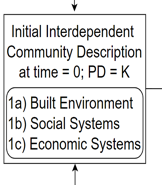

Step 1 in IN-CORE is to establish initial community description at time 0 and with policy levers and decision combinations (PD) set to K (baseline case). The community description includes three parts including **1a) Built Environment**, **1b) Social Systems**, and **1c) Economic Systems**.

## 1a) Built Environment
The Galveston testbed consists of five infrastructure systems as buildings, transportation network, electric power transmission and distribution network, water/wastewater network, and critical facilities. Each infrastructure system may be composed of different infrastructure components. For example, the transportation network consists of bridges and roadways. The infrastructure systems and components are shown below along with their IN-CORE GUID.

| No. | Infrastructure System | Infrastructure Component | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Buildings | - | 60354b6c123b4036e6837ef7| Ref. |
| 2 | Transportation network | Bridges | 60620320be94522d1cb9f7f0| Ref. |
| - | Transportation network | Roadways | 5f15d04f33b2700c11fc9c4e| Ref. |
| 3 | Electric power network | Connectivity | Outside of IN-CORE| Ref. |
| - | Electric power network | Poles and Towers | Outside of IN-CORE| Ref. |
| - | Electric power network | Substation | Outside of IN-CORE| Ref. |
| - | Electric power network | Transmission | Outside of IN-CORE| Ref. |
| - | Electric power network | Underground | Outside of IN-CORE| Ref. |
| 4 | Water/wastewater network | Water mains | Outside of IN-CORE| Ref. |
| - | Water/wastewater network | Water plants | Outside of IN-CORE| Ref. |
| - | Water/wastewater network | Wastewater mains | Outside of IN-CORE| Ref. |
| 5 | Critical facilities | Hospitals | Outside of IN-CORE| Ref. |
| - | Critical facilities | Urgent care | Outside of IN-CORE| Ref. |
| - | Critical facilities | Emergency medical facilities | Outside of IN-CORE| Ref. |
| - | Critical facilities | Fire stations | Outside of IN-CORE| Ref. |
| 6 | Fiber Optic Network | - | Outside of IN-CORE| Ref. |

**Note**: The built environment in the Galveston testbed are in the Galveston Island. However, as the goal is to capture flow of people during recovery stages, buildings and transportation networks in the Galveston mainland are considered as well.

### Buildings
The building inventory for Galveston consists of 18,962 individual residential households. This inventory is also mappable to housing unit info of 32,501 individual households explained later in this notebook. It should be noted that the reason that the building and household data are different in terms of numbers is that each individual building can be composed of a few households. The building inventory consists of three major parameters that are used to estimate the fragility of buildings explained shortly later in this notebook. The three parameters are: 

a) Elevation of the lowest horizontal structural member

b) Age group of the building (1, 2, 3, and 4 representing age group pre-1974, 1974–1987, 1987–1995, and 1995– 2008, respectively) 

c) Elevation of the building with respect to the ground


Dataset already exists locally. Reading from local cached zip.
Unzipped folder found in the local cache. Reading from it...
Galveston testbed building inventory as a function of age group
Number of buildings: 18962


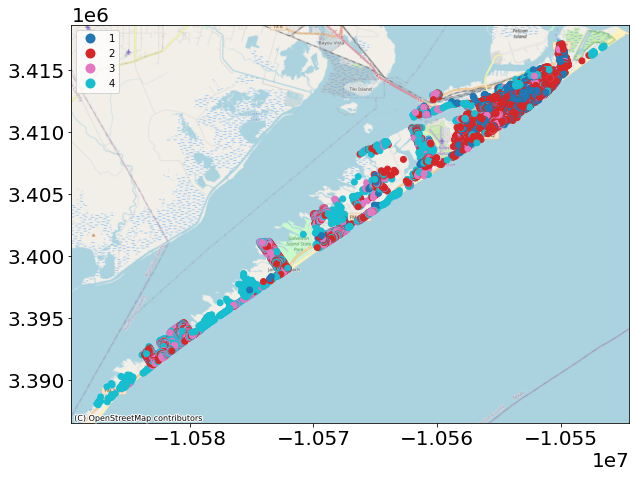

In [10]:
bldg_dataset_id = "60354b6c123b4036e6837ef7"               # defining building dataset (GIS point layer)       
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
geoviz.plot_map(bldg_dataset, column='age_group',category='True')
print('Galveston testbed building inventory as a function of age group')

bldg_df = bldg_dataset.get_dataframe_from_shapefile()
#bldg_df.set_index('guid', inplace=True)
print('Number of buildings: {}' .format(len(bldg_df)))

## 1b) Social Systems
The Galveston Island has a permanent resident population of approximately 53,695 people (US Census, 2020). In 2010, the total population living on Galveston Island was 48,726. This section performs a housing unit allocation. The housing unit inventory includes characteristics for individual households and housing units that can be linked to residential buildings. For more information see Rosenheim et al. (2019).

In [11]:
# Housing Unit inventory
housing_unit_inv_id = "61d783eb3ed7dd5c873b42d2"
# load housing unit inventory as pandas dataframe
housing_unit_inv = Dataset.from_data_service(housing_unit_inv_id, data_service)
filename = housing_unit_inv.get_file_path('csv')
print("The IN-CORE Dataservice has saved the Housing Unit Inventory on your local machine: "+filename)

Dataset already exists locally. Reading from local cached zip.


BadZipFile: File is not a zip file

In [ ]:
housing_unit_inv_df = pd.read_csv(filename, header="infer")
housing_unit_inv_df.head()

In [ ]:
housing_unit_inv_df['huid'].describe()

In [ ]:
poptable.pop_results_table(housing_unit_inv_df, 
                  who = "Total Population by Householder", 
                  what = "by Race, Ethnicity",
                  where = "Galveston County TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

## 1a + 1b) Interdependent Community Description

Explore building inventory and social systems. Specifically look at how the building inventory connects with the housing unit inventory using the housing unit allocation.
The housing unit allocation method will provide detail demographic characteristics for the community allocated to each structure.

To run the HUA Algorithm, three input datasets are required:

1. Housing Unit Inventory - Based on 2010 US Census Block Level Data

2. Address Point Inventory - A list of all possible residential/business address points in a community. Address points are the link between buildings and housing units.

3. Building Inventory - A list of all buildings within a community.


### Set Up and Run Housing Unit Allocation
The building and housing unit inventories have already by loaded. The address point inventory is needed to link the population with the structures.

In [ ]:
# Create housing allocation 
hua = HousingUnitAllocation(client)

address_point_inv_id = "5fc6aadcc38a0722f563392e"

# Load input dataset
hua.load_remote_input_dataset("housing_unit_inventory", housing_unit_inv_id)
hua.load_remote_input_dataset("address_point_inventory", address_point_inv_id)
hua.load_remote_input_dataset("buildings", bldg_dataset_id)

# Specify the result name
result_name = "Galveston_HUA"

seed = 1238
iterations = 1

# Set analysis parameters
hua.set_parameter("result_name", result_name)
hua.set_parameter("seed", seed)
hua.set_parameter("iterations", iterations)

In [ ]:
# Run Housing unit allocation analysis
hua.run_analysis()

### Explore results from Housing Unit Allocation

In [ ]:
# Retrieve result dataset
hua_result = hua.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
hua_df = hua_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
hua_df[['guid','numprec','incomegroup','geometry']].head()

In [ ]:
hua_df[['guid','huid']].describe()

In [ ]:
# Limit HUA Results to only observations with GUID and HUID
hua_df_buildings = hua_df.loc[(hua_df['guid'].notnull()) & 
            (hua_df['huid'].notnull())].copy()
hua_df_buildings[['guid','huid']].describe()

In [ ]:
# Update HUA results with housing unit inventory linked to buildings
hua_result = Dataset.from_dataframe(dataframe = hua_df_buildings,
                                    name = result_name+"_"+str(seed)+"buildings.csv",
                                    data_type='incore:housingUnitAllocation')

In [ ]:
poptable.pop_results_table(hua_df_buildings, 
                  who = "Total Population by Householder", 
                  what = "by Race, Ethnicity",
                  where = "Galveston Island, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

In [ ]:
poptable.pop_results_table(hua_df_buildings, 
                  who = "Median Household Income", 
                  what = "by Race, Ethnicity",
                  where = "Galveston Island, TX - Buildings in Inventory",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Tenure Status')

#### Validate the Housing Unit Allocation has worked
Notice that the population count totals for the community should match (pretty closely) data collected for the 2010 Decennial Census.
This can be confirmed by going to data.census.gov

Total Population by Race and Ethnicity:
https://data.census.gov/cedsci/table?q=DECENNIALPL2010.P5&g=1600000US4828068,4837252&tid=DECENNIALSF12010.P5

Median Income by Race and Ethnicity:
- All Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013
- Black Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013B
- White, not Hispanic Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013H
- Hispanic Households: https://data.census.gov/cedsci/table?g=1600000US4828068,4837252&tid=ACSDT5Y2012.B19013I
    
Differences in the housing unit allocation and the Census count may be due to differences between political boundaries and the building inventory. See Rosenheim et al 2019 for more details.

The housing unit allocation, plus the building results will become the input for the social science models such as the population dislocation model.

# 2) Hazards and Damages

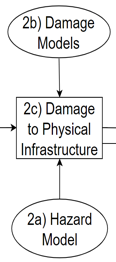

## 2a) Hazard Model (Hurricane)
There are currently five hurricane hazard data for Galveston testbed. Four of them were created using the dynamically coupled versions of the Advanced Circulation (ADCIRC) and Simulating Waves Nearshore (SWAN) models. One of them is a surrogate model developed using USACE datasets.

| No. | Simulation type | Name | GUID | More details |
| --- | --- | --- | --- | --- |
| 1 | Coupled ADCIRC+SWAN | Hurricane Ike Hindcast | <font color='red'>5fa5a228b6429615aeea4410 </font> | Darestani et al. (2021) |
| 2 | Coupled ADCIRC+SWAN | 2% AEP Hurricane Simulation | <font color='red'>5fa5a83c7e5cdf51ebf1adae </font> | Darestani et al. (2021) |
| 3 | Coupled ADCIRC+SWAN | 1% AEP Hurricane Simulation | <font color='red'>5fa5a9497e5cdf51ebf1add2 </font> | Darestani et al. (2021) |
| 4 | Coupled ADCIRC+SWAN | 0.2% AEP Hurricane Simulation | <font color='red'>5fa5aa19b6429615aeea4476 </font> | Darestani et al. (2021) |
| 5 | Kriging-based surrogate model | Galveston Deterministic Hurricane - Kriging | <font color='red'>5f15cd627db08c2ccc4e3bab </font> | Fereshtehnejad et al. (2021) |


### Coupled ADCIRC+SWAN
Galveston Island was struck by Hurricane Ike in September, 2008, with maximum windspeeds of 49 m/s (95 kts) and storm surge elevations reaching at least +3.5 m (NAVD88) on Galveston Island. A full hindcast of Hurricane Ike’s water levels, and wave conditions along with 2% (50-yr return period), 1% (100-yr return period), and 0.2% (500-yr return period) Annual Exceedance Probabilities (AEP) hurricane simulations were created using ADCIRC+SWAN models. These hurricane hazard events contain **eight hazardDatasets**, which is five more than the current pyincore hurricane schema. Please be sure to adjust your codes accordingly if you need to incorporate the five new intensity measures (IMs). The existing schema includes the peak significant wave height, peak surge level, and inundation duration. These new events include those as well as maximum inundation depth, peak wave period, wave direction, maximum current speed, and maximum wind speed. 

### Kriging-based surrogate model
**Three hazardDatasets** of kriging-based surrogate models are developed for peak significant wave height, peak surge level, and inundation duration. Training datasets for developing the Kriging surorgate models were collected through USACE. For the peak significant wave height, peak surge level, and inundation duration the training datasets included 61, 251, and 254 synthetic storms, respectively. 

### Building damage

### 2.1 Building Fragility

The fragility model used to estimate failure probability during storm surge events is extracted from:

>Tomiczek, T. Kennedy, A, and Rogers, S., 2013. Collapse limit state fragilities of wood-framed residences from storm surge and waves during Hurricane Ike. Journal of Waterway, Port, Coastal, and Ocean Engineering, 140(1), pp.43-55.

This empirical fragility model was developed based on Hurricane Ike surveys of almost 2000 individual wood-frame buildings coupled with high resolution hindcast of the hurricane. For this study two states of damage, “Collapse” and “Survival” were considered.
________________________________________
The input parameters to the fragility model are:

1) Surge: surge level (m) coming from hazard data

2) Hs: Significant wave height (m) coming from hazard data

3) LHSM: Elevation of the lowest horizontal structural member (ft) coming from building inventory

4) age_group: Age group of the building (1, 2,3, and 4 representing age group pre-1974, 1974–1987, 1987–1995, and 1995– 2008, respectively) coming from building Inventory

5) G_elev: Elevation of the building with respect to the ground (m) coming from building inventory
________________________________________
Output:
Pf: probability of failure
________________________________________
In order to calculate the probability of failure, first we need to estimate the relative surge height compared to the ground level from:
𝑑𝑠=𝑆𝑢𝑟𝑔𝑒−𝐺𝑒𝑙𝑒𝑣ds

Subsequently, we need to calculate the following parameter

𝐹𝐵ℎ𝑠=−(𝑑𝑠+0.7∗𝐻𝑠−𝐿𝐻𝑆𝑀∗0.3048)
Note: 0.3048 is to convert ft to m as the inventory data are in ft.

Then:

For FB_hs>= -2.79*Hs the probability of failure is calculated as:
𝑃𝑓=Φ(−3.56+1.52∗𝐻𝑠−1.73∗𝐻𝑠∗𝐹𝐵ℎ𝑠−0.31∗𝐹𝐵2ℎ𝑠−0.141∗𝑎𝑔𝑒2𝑔𝑟𝑜𝑢𝑝)

and for FB_hs< -2.79*Hs
𝑃𝑓=Φ(−3.56+1.52∗𝐻𝑠+2.42∗𝐹𝐵2ℎ𝑠−0.141∗𝑎𝑔𝑒2𝑔𝑟𝑜𝑢𝑝)
Where Φ denotes the Cumulative Density Function (CDF) of standard normal distribution.
________________________________________
Example:
If Surge=3 m, Hs =2 m, LHSM=9 ft, age_group=4; G_elev =1 m
Then Pf= 0.2620


In [ ]:
# use utility method of pyicore-viz package to visualize the fragility
fragility_set = FragilityCurveSet(FragilityService(client).get_dfr3_set("5f6ccf67de7b566bb71b202d"))
plt = plotviz.get_fragility_plot_3d(fragility_set, 
                                            title="Galveston empirical fragility model developed "
                                            "based on Hurricane Ike surveys",
                                            limit_state="LS_0")
plt.show()

In [ ]:
hazard_type = "hurricane"
# Galveston deterministic Hurricane, 3 datasets - Kriging
hazard_id = "5fa5a228b6429615aeea4410"
# visualization
wave_height_id = "5f15cd62c98cf43417c10a3f"
surge_level_id = "5f15cd5ec98cf43417c10a3b"

# Hurricane building mapping (with equation)
mapping_id = "602c381a1d85547cdc9f0675"
fragility_service = FragilityService(client)
mapping_set = MappingSet(fragility_service.get_mapping(mapping_id))

In [ ]:
# visualize wave height
dataset = Dataset.from_data_service(wave_height_id, DataService(client))
map = geoviz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

In [ ]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

In [ ]:
# visualize surge level
dataset = Dataset.from_data_service(surge_level_id, DataService(client))
map = geoviz.map_raster_overlay_from_file(dataset.get_file_path('tif'))
map

In [ ]:
# add opacity control - NOTE: It takes time before the opacity takes effect.
map.layers[1].interact(opacity=(0.0,1.0,0.01))

### 2.2 Building Damage

In [ ]:
bldg_dmg = BuildingDamage(client)

bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

In [ ]:
result_name = "Galveston_bldg_dmg_result"

bldg_dmg.set_parameter("fragility_key", "Hurricane SurgeLevel and WaveHeight Fragility ID Code")
bldg_dmg.set_parameter("result_name", result_name)
bldg_dmg.set_parameter("hazard_type", hazard_type)
bldg_dmg.set_parameter("hazard_id", hazard_id)
bldg_dmg.set_parameter("num_cpu", 4)

In [ ]:
bldg_dmg.run_analysis()

# 3) Functionality

## 3a) Functionality Models

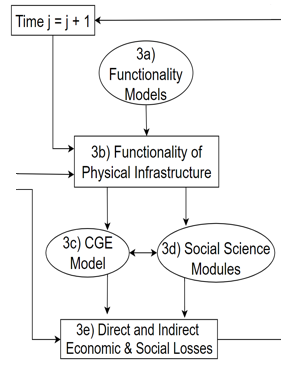

## 3b) Functionality of Physical Infrastructure

In [ ]:
# Retrieve result dataset
building_dmg_result = bldg_dmg.get_output_dataset('ds_result')

In [ ]:
# Convert dataset to Pandas DataFrame
bdmg_df = building_dmg_result.get_dataframe_from_csv(low_memory=False)

# Display top 5 rows of output data
bdmg_df.head()

In [ ]:
bdmg_df.DS_0.describe()

In [ ]:
bdmg_df.DS_3.describe()

## 3d) Social Science Modules

Population Dislocation
Population dislocation refers to households that will be forced to leave their pre-event residence due to hazard related damages. Population dislocation is a function of structure value loss due to damage, neighborhood characteristics and structure type.

#### 3d.1 Use new pyincore-data utility to obtain Block Group Data for County

In [ ]:
from pyincore_data.censusutil import CensusUtil
state_counties = ['48167']
blockgroup_df, bgmap = CensusUtil.get_blockgroupdata_for_dislocation(state_counties, 
                                                out_csv=True, 
                                                out_shapefile=False, 
                                                out_html=False,
                                                program_name = "BlockGroupData",
                                                geo_name = "Galveston")

In [ ]:
blockgroup_df.head()


In [ ]:
bg_data = Dataset.from_file(
    'BlockGroupData/BlockGroupData_Galveston.csv',
    'incore:blockGroupData')

#### 3d.2 Population Dislocation

In [ ]:
pop_dis = PopulationDislocation(client)


In [ ]:
# Value loss parameters DS 0-3
value_loss = "60354810e379f22e16560dbd"

In [ ]:
pop_dis.set_input_dataset("block_group_data", bg_data)
pop_dis.load_remote_input_dataset("value_loss_param", value_loss)

pop_dis.set_input_dataset("building_dmg", building_dmg_result)
pop_dis.set_input_dataset("housing_unit_allocation", hua_result)

result_name = "galveston-pop-disl-results"
seed = 1111

pop_dis.set_parameter("result_name", result_name)
pop_dis.set_parameter("seed", seed)

In [ ]:
pop_dis.run_analysis()

#### 3.d.3 Explore Population Dislocation Results

In [ ]:
# Retrieve result dataset
population_dislocation_result = pop_dis.get_output_dataset("result")

# Convert dataset to Pandas DataFrame
pd_df = population_dislocation_result.get_dataframe_from_csv(low_memory=False)

In [ ]:
poptable.pop_results_table(pd_df, 
                  who = "Total Population by Households", 
                  what = "by Tenure Status and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Tenure Status",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

In [ ]:
poptable.pop_results_table(pd_df, 
                  who = "Total Population by Households", 
                  what = "by Race, Ethnicity and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Race Ethnicity",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

In [ ]:
# Add household income group categories for table
# Code will be added to next release of pop_results_table on pyincore-viz
def add_label_cat_conditions_df(df, conditions):
    """Label Categorical Variable Values and add to dataframe.
    Use this function with values are based on conditions.
    
    Args:
        df (obj): Pandas DataFrame object.
        conditions (dict): Dictionary of conditions for value labels.
    Returns:
        object: Pandas DataFrame object.
    """

    cat_var = conditions['cat_var']['variable_label']

    df[cat_var] = "No Data"

    for item in conditions['condition_list'].keys():
        condition =  conditions['condition_list'][item]['condition']
        value_label = conditions['condition_list'][item]['value_label']
        df.loc[eval(condition), cat_var] = value_label

    # Set variable to missing if no data- makes tables look nicer
    df.loc[(df[cat_var] == "No Data"), 
        cat_var] = np.nan

    return df

def add_label_cat_values_df(df, valuelabels, variable = ''):
    """Label Categorical Variable Values and add to dataframe.
    Use this function with categorical values 
    are integer values.
    Args:
        df (obj): Pandas DataFrame object.
        valuelabels (dict): Dictionary of value labels.
        variable (str): Variable to label.
    Returns:
        object: Pandas DataFrame object with new column that has value labels.
    """

    if variable == '':
        variable  = valuelabels['categorical_variable']['variable']
    variable_label = valuelabels['categorical_variable']['variable_label']

    df[variable_label] = "No Data"

    for item in valuelabels['value_list'].keys():
        value =  valuelabels['value_list'][item]['value']
        value_label = valuelabels['value_list'][item]['value_label']
        df.loc[df[variable] == value, variable_label] = value_label

    # Set variable to missing if no data- makes tables look nicer
    df.loc[(df[variable_label] == "No Data"), 
        variable_label] = np.nan

    return df

hhinc_valuelabels = {'categorical_variable': {'variable' : 'hhinc',
                                'variable_label' : 'Household Income Group',
                                'notes' : '5 Household Income Groups based on random income.'},
                    'value_list' : {
                        1 : {'value': 1, 'value_label': "1 Less than $15,000"},
                        2 : {'value': 2, 'value_label': "2 $15,000 to $24,999"},
                        3 : {'value': 3, 'value_label': "3 $25,000 to $74,999"},
                        4 : {'value': 4, 'value_label': "4 $75,000 to $99,999"},
                        5 : {'value': 5, 'value_label': "5 $100,000 or more"}}
                    }

pd_df = add_label_cat_values_df(pd_df, valuelabels = hhinc_valuelabels)

In [ ]:
poptable.pop_results_table(pd_df, 
                  who = "Total Households", 
                  what = "by Household Income Group and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = "Household Income Group",
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

#### 3.d.4 Explore Population Dislocation and Building Damage Results

In [ ]:
ds3_conditions = {'cat_var' : {'variable_label' : 'Probability Complete Failure',
                         'notes' : 'Probability of complete failure based on damage state 3'},
              'condition_list' : {
                1 : {'condition': "(df['DS_3'] == 0)", 'value_label': "0 0%"},
                2 : {'condition': "(df['DS_3'] > 0)", 'value_label': "1 Less than 20%"},
                3 : {'condition': "(df['DS_3'] > .2)", 'value_label': "2 20-40%"},
                4 : {'condition': "(df['DS_3'] > .4)", 'value_label': "3 40-60%"},
                5 : {'condition': "(df['DS_3'] > .6)", 'value_label': "4 60-80%"},
                6 : {'condition': "(df['DS_3'] > .8)", 'value_label': "5 80-100%"},
                7 : {'condition': "(df['DS_3'] == 1)", 'value_label': "6 100%"}}
            }

      
dsf_valuelabels = {'categorical_variable' : {'variable' : 'd_sf',
                   'variable_label' : 'Single Family Dwelling',
                   'notes' : 'Categories for single family dwellings'},
              'value_list' : {
                1 : {'value': 0, 'value_label': "0 Not Single Family"},
                2 : {'value': 1, 'value_label': "1 Single Family"}}
            }

In [ ]:

pd_df = add_label_cat_conditions_df(pd_df, conditions = ds3_conditions)
pd_df = add_label_cat_values_df(pd_df, valuelabels = dsf_valuelabels)

In [ ]:
poptable.pop_results_table(pd_df, 
                  who = "Total Households", 
                  what = "by Probability of Complete Failure and Dislocation",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Probability Complete Failure',
                  col_index = 'Population Dislocation',
                  row_percent = '1 Dislocates')

In [ ]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8)], 
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Single Family Dwelling",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Single Family Dwelling',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

In [ ]:
poptable.pop_results_table(pd_df.loc[(pd_df['DS_3'] > .8)], 
                  who = "Total Population by Households", 
                  what = "for High Damaged Structures by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Population Dislocation',
                  row_percent = '0 Does not dislocate')

# 4) Recovery

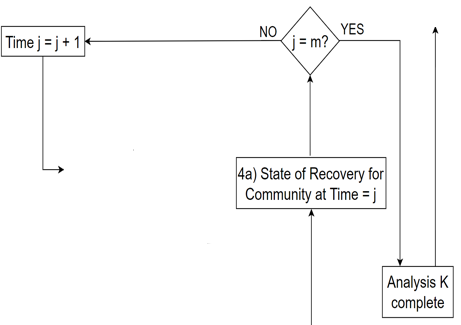

* **j** is the index for time 
* **m** is the community lifetime
* **K** is the index for policy levers and decision combinations (PD)

### 4.1 Household-Level Housing Recovery Analysis

The Household-Level Housing Recovery (HHHR) model developed by Sutley and Hamideh (2020) is used to simulate the housing recovery process of dislocated households.

The computation operates by segregating household units into five zones as a way of assigning social vulnerability. Then, using this vulnerability in conjunction with the Transition Probability Matrix (TPM) and the initial state vector, a Markov chain computation simulates the most probable states to generate a stage history of housing recovery changes for each household. The detailed process of the HHHR model can be found in Sutley and Hamideh (2020).

>Sutley, E.J. and Hamideh, S., 2020. Postdisaster housing stages: a Markov chain approach to model sequences and duration based on social vulnerability. Risk Analysis, 40(12), pp.2675-2695.

The Markov chain model consists of five discrete states at any time throughout the housing recovery process. The five discrete states represent stages in the household housing recovery process, including emergency shelter (1), temporary shelter (2); temporary housing (3); permanent housing (4), and failure to recover (5). The model assumes that a household can be in any of the first four stages immediately after a disaster. If the household reported not being dislocated, household will begin in stage 4. 

### 4.2 Set Up and Run Household-level Housing Sequential Recovery

In [ ]:
# Transition probability matrix per social vulnerability level, from Sutley and Hamideh (2020).
transition_probability_matrix = "60f5e2ae544e944c3cec0794"
# Initial mass probability function for household at time 0
initial_probability_vector = "60f5e918544e944c3cec668b"

## Population Dislocation results error
the blockid is too big to make a int first - need to either use 'int64' of convert to int64 first before converting to int

In [ ]:
# Create housing recovery instance
housing_recovery = HousingRecoverySequential(client)

# Load input datasets from dislocation, tpm, and initial probability function
#housing_recovery.load_remote_input_dataset("population_dislocation_block", population_dislocation)
housing_recovery.set_input_dataset("population_dislocation_block", population_dislocation_result)

housing_recovery.load_remote_input_dataset("tpm", transition_probability_matrix)
housing_recovery.load_remote_input_dataset("initial_stage_probabilities", initial_probability_vector)

In [ ]:
# Initial value to seed the random number generator to ensure replication
seed = 1234
# A size of the analysis time step in month
t_delta = 1.0
# Total duration of Markov chain recovery process
t_final = 90.0

In [ ]:
# Specify the result name
result_name = "housing_recovery_result"

# Set analysis parameters
housing_recovery.set_parameter("result_name", result_name)
housing_recovery.set_parameter("seed", seed)
housing_recovery.set_parameter("t_delta", t_delta)
housing_recovery.set_parameter("t_final", t_final)

# Run the household recovery sequence analysis - Markov model
housing_recovery.run()

## 6 a) Sufficient Quality Solutions Found?

In [ ]:
# Retrieve result dataset
housing_recovery_result = housing_recovery.get_output_dataset("ds_result")

# Convert dataset to Pandas DataFrame
df_hhrs = housing_recovery_result.get_dataframe_from_csv()

# Display top 5 rows of output data
df_hhrs.head()


> Plot Housing Recovery Sequence Results

>view recovery sequence results for specific households

In [ ]:
df=df_hhrs.drop(['guid', 'huid', 'Zone', 'SV'], axis=1)
df=df.to_numpy()
t_final=int(t_final)-1

# Plot stage histories and stage changes using pandas.
# Generate timestep labels for dataframes.
label_timestep = []
for i4 in range(0, t_final):
    label_timestep.append(str(i4))
    
ids = [4, 19,48] # select specific household by id numbers
for id in ids:
    HH_stagehistory_DF = pd.DataFrame(np.transpose(df[id, 1:]),
                                      index=label_timestep)
    ax = HH_stagehistory_DF.reset_index().plot(x='index',
                                               yticks=[1, 2, 3, 4, 5],
                                               title='Household Recovery Sequences',
                                               legend=False)
    ax.set(xlabel='Timestep (months)', ylabel='Stage')
    y_ticks_labels = ['1','2','3','4','5']
    ax.set_xlim(0,80)
    ax.set_yticklabels(y_ticks_labels, fontsize = 14)

> Plot recovery heatmap any stage of recovery

In [ ]:
df_hhrs.head()

In [ ]:
# merge household unit information with recovery results
pd_df_hs = pd.merge(left = pd_df, 
                    right = df_hhrs,
                    left_on=['guid','huid'],
                    right_on=['guid','huid'],
                    how='left')

In [ ]:
pd_df_hs[['guid','huid']].describe()

In [ ]:
recovery_data = pd_df_hs[['y','x','numprec']].loc[pd_df_hs['85']==5].values.tolist()

In [ ]:
len(recovery_data)

> Plot recovery heatmap after 12 months of recovery

In [ ]:
from ipyleaflet import Map, Heatmap, LayersControl, LegendControl

# What location should the map be centered on?
center_x = pd_df_hs['x'].mean()
center_y = pd_df_hs['y'].mean()

map = Map(center=[center_y, center_x], zoom=11)

stage5_data = pd_df_hs[['y','x','numprec']].loc[pd_df_hs['85']==5].values.tolist()
stage5 = Heatmap(
    locations = stage5_data,
    radius = 5, 
    max_val = 1000, 
    blur = 10, 
    gradient={0.2: 'yellow', 0.5: 'orange', 1.0: 'red'},
    name = 'Stage 5 - Failure to Recover',
)

stage4_data = pd_df_hs[['y','x','numprec']].loc[pd_df_hs['85']==4].values.tolist()
stage4 = Heatmap(
    locations = stage4_data,
    radius = 5, 
    max_val = 1000, 
    blur = 10, 
    gradient={0.2: 'purple', 0.5: 'blue', 1.0: 'green'},
    name = 'Stage 4 - Permanent Housing',
)

map.add_layer(stage4)
map.add_layer(stage5)


control = LayersControl(position='topright')
map.add_control(control)
map


The five discrete states represent stages in the household housing recovery process, including emergency shelter (1), temporary shelter (2); temporary housing (3); permanent housing (4), and failure to recover (5). The model assumes that a household can be in any of the first four stages immediately after a disaster.

In [ ]:
hhrs_valuelabels = {'categorical_variable' : {'variable' : 'select time step',
                   'variable_label' : 'Household housing recovery stages',
                   'notes' : 'Sutley and Hamideh recovery stages'},
              'value_list' : {
                1 : {'value': 1, 'value_label': "1 Emergency Shelter"},
                2 : {'value': 2, 'value_label': "2 Temporary Shelter"},
                3 : {'value': 3, 'value_label': "3 Temporary Housing"},
                4 : {'value': 4, 'value_label': "4 Permanent Housing"},
                5 : {'value': 5, 'value_label': "5 Failure to Recover"}}
            }

permanenthousing_valuelabels = {'categorical_variable' : {'variable' : 'select time step',
                   'variable_label' : 'Permanent Housing',
                   'notes' : 'Sutley and Hamideh recovery stages'},
              'value_list' : {
                1 : {'value': 1, 'value_label': "0 Not Permanent Housing"},
                2 : {'value': 2, 'value_label': "0 Not Permanent Housing"},
                3 : {'value': 3, 'value_label': "0 Not Permanent Housing"},
                4 : {'value': 4, 'value_label': "1 Permanent Housing"},
                5 : {'value': 5, 'value_label': "0 Not Permanent Housing"}}
            }

pd_df_hs = add_label_cat_values_df(pd_df_hs, valuelabels = hhrs_valuelabels, variable = '13')
pd_df_hs = add_label_cat_values_df(pd_df_hs, valuelabels = permanenthousing_valuelabels,
                        variable = '13')

In [ ]:
poptable.pop_results_table(pd_df_hs, 
                  who = "Total Population by Householder", 
                  what = "by Housing Type at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Household housing recovery stages',
                  row_percent = '2 Temporary Shelter'
                  )

In [ ]:
poptable.pop_results_table(pd_df_hs, 
                  who = "Total Population by Householder", 
                  what = "by Permanent Housing at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010",
                  row_index = 'Race Ethnicity',
                  col_index = 'Permanent Housing',
                  row_percent = "0 Not Permanent Housing"
                  )

## 8b) Policy Lever and Decision Combinations
Hypothetical scenario to elevate all buildings in inventory.

In [ ]:
bldg_gdf_policy2 = bldg_df.copy()
for i in range(18): 
    
    ################## 1a) updated building inventory ##################  
    print(f"Running Analysis: {i}")
    if i>0:
        bldg_gdf_policy2.loc[bldg_gdf_policy2['lhsm_elev'].le(16), 'lhsm_elev'] += 1
        bldg_gdf_policy2.to_csv(f'input_df_{i}.csv')
    # Save new shapefile and then use as new input to building damage model
    bldg_gdf_policy2.to_file(driver = 'ESRI Shapefile', filename = f'bldg_gdf_policy_{i}.shp')
    # Plot and save
    geoviz.plot_gdf_map(bldg_gdf_policy2, column='lhsm_elev',category='False')
    # Code to save the results here
    ####################################################################      
    #
    #
    ################## 2c) Damage to Physical Infrastructure ##################  
    building_inv_policy2 = Dataset.from_file(file_path = f'bldg_gdf_policy_{i}.shp',
                                        data_type='ergo:buildingInventoryVer7')

    bldg_dmg = BuildingDamage(client)
    #bldg_dmg.load_remote_input_dataset("buildings", bldg_dataset_id)
    bldg_dmg.set_input_dataset("buildings", building_inv_policy2)
    bldg_dmg.set_input_dataset("dfr3_mapping_set", mapping_set)

    result_name = "Galveston_bldg_dmg_result"

    bldg_dmg.set_parameter("fragility_key", "Hurricane SurgeLevel and WaveHeight Fragility ID Code")
    bldg_dmg.set_parameter("result_name", result_name)
    bldg_dmg.set_parameter("hazard_type", hazard_type)
    bldg_dmg.set_parameter("hazard_id", hazard_id)
    bldg_dmg.set_parameter("num_cpu", 4)

    bldg_dmg.run_analysis()
    ###########################################################################
    #
    #
    ################## 3b) Functionality of Physical Infrastructure ##################
    # Retrieve result dataset
    building_dmg_result_policy2 = bldg_dmg.get_output_dataset('ds_result')
    # Convert dataset to Pandas DataFrame
    bdmg_policy2_df = building_dmg_result_policy2.get_dataframe_from_csv(low_memory=False)
    # Save CSV files for post processing
    bdmg_policy2_df.to_csv(f"bld_damage_results_policy_{i}.csv")
    ##################################################################################
    #
    #
    ############################  3d) Social Science Modules ############################   
    # update building damage
    pop_dis.set_input_dataset("building_dmg", building_dmg_result_policy2)

    # Update file name for saving results
    result_name = "galveston-pop-disl-results_policy2"
    pop_dis.set_parameter("result_name", result_name)
    
    pop_dis.run_analysis()
    
    # Retrieve result dataset
    population_dislocation_result_policy2 = pop_dis.get_output_dataset("result")

    # Convert dataset to Pandas DataFrame
    pd_df_policy2 = population_dislocation_result_policy2.get_dataframe_from_csv(low_memory=False)
    # Save CSV files for post processing
    pd_df_policy2.to_csv(f"pd_df_results_policy_{i}.csv")
    ######################################################################################
    #
    #
    ############################  4) Recovery ############################   
    # Update population dislocation
    housing_recovery.set_input_dataset("population_dislocation_block", 
                            population_dislocation_result_policy2)
    # Update file name for saving results
    result_name = "housing_recovery_result_policy2"
    # Set analysis parameters
    housing_recovery.set_parameter("result_name", result_name)
    housing_recovery.set_parameter("seed", seed)
    
    # Run the household recovery sequence analysis - Markov model
    housing_recovery.run()
    
    # Retrieve result dataset
    housing_recovery_result_policy2 = housing_recovery.get_output_dataset("ds_result")

    # Convert dataset to Pandas DataFrame
    df_hhrs_policy2 = housing_recovery_result_policy2.get_dataframe_from_csv()
    # Save CSV files for post processing
    df_hhrs_policy2.to_csv(f"df_hhrs_results_policy_{i}.csv")

# POST PROCESSING

In [ ]:
# choose i between 1 to 17
i = 3

## Postprocessing: Functionality of Physical Infrastructure

In [ ]:
bdmg_df = pd.read_csv ('bld_damage_results_policy_0.csv')
bdmg_policy2_df = pd.read_csv (f"bld_damage_results_policy_{i}.csv")

f'bldg_gdf_policy_{i}.shp'
# Merge policy i with policy j
bdmg_df_policies = pd.merge(left = bdmg_df,
                      right = bdmg_policy2_df,
                      on = 'guid',
                      suffixes = ('_policy0', f'_policy{i}'))
bdmg_df_policies[['DS_0_policy0',f'DS_0_policy{i}']].describe().T

In [ ]:
bdmg_df_policies[['DS_3_policy0',f'DS_3_policy{i}']].describe().T

In [ ]:
import matplotlib.pyplot as plt
# Scatter Plot
plt.scatter(bdmg_df_policies['DS_3_policy0'], bdmg_df_policies[f'DS_3_policy{i}'])
plt.title(f'Scatter plot Policy 0 vs Policy {i}')
plt.xlabel('Complete Damage Policy 0')
plt.ylabel(f'Complete Damage Policy {i}')
plt.savefig(f'CompleteDamage{i}.tif', dpi = 200)
plt.show()

In [ ]:
bdmg_df_policies['DS_3_policy0']

## Postprocessing: Social Science Modules

## Postprocessing: Recovery

In [ ]:
df_hhrs_policy2 = pd.read_csv (f"df_hhrs_results_policy_{i}.csv")
# merge household unit information with recovery results
pd_df_hs_policy2 = pd.merge(left = pd_df_policy2, 
                    right = df_hhrs_policy2,
                    left_on=['guid','huid'],
                    right_on=['guid','huid'],
                    how='left')
pd_df_hs_policy2[['guid','huid']].describe()

## 6a) Sufficient Quality Solutions Found?

In [ ]:
pd_df_policy2 = pd.read_csv(f'pd_df_results_policy_{i}.csv')
df_hhrs_policy2 = pd.read_csv(f'df_hhrs_results_policy_{i}.csv')

pd_df_hs_policy2 = pd.merge(left = pd_df_policy2, 
                    right = df_hhrs_policy2,
                    left_on=['guid','huid'],
                    right_on=['guid','huid'],
                    how='left')

In [ ]:
# Add HHRS categories to dataframe
pd_df_hs_policy2 = add_label_cat_values_df(pd_df_hs_policy2, 
            valuelabels = hhrs_valuelabels, variable = '13')
pd_df_hs_policy2 = add_label_cat_values_df(pd_df_hs_policy2, 
            valuelabels = permanenthousing_valuelabels,
                        variable = '13')

In [ ]:
poptable.pop_results_table(pd_df_hs_policy2, 
                  who = "Total Population by Householder", 
                  what = "by Permanent Housing at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010 - Policy 2 - All buildings elvated",
                  row_index = 'Race Ethnicity',
                  col_index = 'Permanent Housing',
                  row_percent = '0 Not Permanent Housing'
                  )

In [ ]:
poptable.pop_results_table(pd_df_hs, 
                  who = "Total Population by Householder", 
                  what = "by Permanent Housing at T=13 by Race Ethnicity",
                  where = "Galveston Island TX",
                  when = "2010 - Baseline",
                  row_index = 'Race Ethnicity',
                  col_index = 'Permanent Housing',
                  row_percent = '0 Not Permanent Housing'
                  )

In [ ]:
def plot_gdf_map(gdf, column, category=False, basemap=True, source=ctx.providers.OpenStreetMap.Mapnik):
        """Plot Geopandas DataFrame.

        Args:
            gdf (obj): Geopandas DataFrame object.
            column (str): A column name to be plot.
            category (bool): Turn on/off category option.
            basemap (bool): Turn on/off base map (e.g. openstreetmap).
            source(obj): source of the Map to be used. examples, ctx.providers.OpenStreetMap.Mapnik (default),
                ctx.providers.Stamen.Terrain, ctx.providers.CartoDB.Positron etc.

        """
        gdf = gdf.to_crs(epsg=3857)
        ax = gdf.plot(figsize=(10, 10), column=column, 
                      legend=True, categorical=category) 

        if basemap:
            ctx.add_basemap(ax, source=source)

In [ ]:
bld_damage_results_policy_0_df = gpd.read_file('bld_damage_results_policy_0.csv')
bld_damage_results_policy_0_df.crs = 'epsg:4326'
bld_damage_results_policy_0_df['geometry'] = bldg_gdf_policy2['geometry']
plot_gdf_map(bld_damage_results_policy_0_df, column='DS_3',category='False')

In [ ]:
bld_damage_results_policy_4_df = gpd.read_file('bld_damage_results_policy_4.csv')
bld_damage_results_policy_4_df.crs = 'epsg:4326'
bld_damage_results_policy_4_df['geometry'] = bldg_gdf_policy2['geometry']
plot_gdf_map(bld_damage_results_policy_4_df, column='DS_3',category='False')

Yes - elevating all buildings in the inventory to 17 feet reduces dislocation from 20.6% to 0.2% and increases the population in permanent housing at t=13 from 42,353 to 45,405.

In [ ]:
bld_damage_results_policy_17_df = gpd.read_file('bld_damage_results_policy_17.csv')
bld_damage_results_policy_17_df.crs = 'epsg:4326'
bld_damage_results_policy_17_df['geometry'] = bldg_gdf_policy2['geometry']

In [ ]:
PF=np.array(bld_damage_results_policy_17_df['DS_3'])
# gdf = gpd.read_file('Galveston Building Inventory ShapeFile/Building.shp')
# gdf = gdf.to_crs(epsg=3857)  # To fix the error you may try this in command window: pip uninstall pyproj and pip install pyproj
# # np.size(gdf,0)
fig, ax = plt.subplots(figsize=(24, 12))

bldg_df.plot(column=PF,categorical=False,legend=True,ax=ax,alpha=0.1)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()
# print(gdf)
# print('Household inventory probability of damage')

In [ ]:
gdf = gpd.read_file('Galveston Building Inventory ShapeFile/Building.shp')
gdf = gdf.to_crs(epsg=3857)  # To fix the error you may try this in command window: pip uninstall pyproj and pip install pyproj
# # np.size(gdf,0)
fig, ax = plt.subplots(figsize=(24, 12))

gdf.plot(column=PF_household,categorical=False,legend=True,ax=ax,alpha=0.1)
ctx.add_basemap(ax)
ax.set_axis_off()
plt.show()
# print(gdf)
print('Household inventory probability of damage')

In [ ]:
bldg_dataset_id = "60354b6c123b4036e6837ef7"               # defining building dataset (GIS point layer)       
bldg_dataset = Dataset.from_data_service(bldg_dataset_id, data_service)
geoviz.plot_map(bldg_dataset, column='age_group',category='True')
print('Galveston testbed building inventory as a function of age group')

bldg_df = bldg_dataset.get_dataframe_from_shapefile()
#bldg_df.set_index('guid', inplace=True)
print('Number of buildings: {}' .format(len(bldg_df)))

In [ ]:
PF=bld_damage_results_policy_17_df['DS_3'].to_numpy()

In [ ]:
PF

In [ ]:
variable_name[PF]